In [0]:
#importing required packages
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split as tts, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score

In [20]:
#Loading train set
train=pd.read_csv("/content/drive/My Drive/HR Analytics/train_LZdllcl.csv")
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [21]:
#Checking size of datset 
train.shape

(54808, 14)

In [22]:
#Checking for different datypes of different features
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [23]:
#Checking for missing values
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [0]:
#Imputing missing values with mode of respective columns
train["education"].fillna(train["education"].mode()[0],inplace=True)
train["previous_year_rating"].fillna(train["previous_year_rating"].mode()[0],inplace=True)

In [25]:
#Checking for missing values after imputation
train.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [0]:
#Dividing dataset into numerical and categorical columns
numerical=train.select_dtypes(include=np.number)
categorical=train.select_dtypes(exclude=np.number)

In [27]:
numerical.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,1,0,49,0
1,65141,1,30,5.0,4,0,0,60,0
2,7513,1,34,3.0,7,0,0,50,0
3,2542,2,39,1.0,10,0,0,50,0
4,48945,1,45,3.0,2,0,0,73,0


In [28]:
categorical.head()

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


In [0]:
#Function to calculate Cramer's Correlation Co-efficient 
def cramers_v_correlation(col1, col2):
    matrix = pd.crosstab(train[col1],train[col2])
    chi2 = ss.chi2_contingency(matrix)[0]
    n = matrix.sum().sum()
    phi2 = chi2/n
    r,k = matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [30]:
#Calculating correlation for categorical variables
for col_1 in list(categorical):
    for col_2 in list(categorical):
        #if((cramers_v_correlation(col_1,col_2)>0.8) and (col_1!=col_2)):
        if(col_1!=col_2):
            print(col_1,"to",col_2,"correlation is",cramers_v_correlation(col_1,col_2))

department to region correlation is 0.13192511922640962
department to education correlation is 0.12822141249182845
department to gender correlation is 0.28638314457029806
department to recruitment_channel correlation is 0.0622030578722607
region to department correlation is 0.13192511922640962
region to education correlation is 0.1753863495058916
region to gender correlation is 0.16147466835421295
region to recruitment_channel correlation is 0.1104784207664475
education to department correlation is 0.12822141249182845
education to region correlation is 0.17538634950589158
education to gender correlation is 0.03493329552792097
education to recruitment_channel correlation is 0.024854735570967432
gender to department correlation is 0.28638314457029806
gender to region correlation is 0.16147466835421295
gender to education correlation is 0.03493329552792096
gender to recruitment_channel correlation is 0.007556611146353458
recruitment_channel to department correlation is 0.06220305787226071

In [0]:
#Function for Chi-Square test for feature importance
def Chi_square(col_1,col_2):
    X=train[col_1].astype('str')
    Y=train[col_2].astype('str')
    observed_values=pd.crosstab(Y,X)
    chi2, p, dof, expected = ss.chi2_contingency(observed_values)
    if(p>0.05):
        print(col_1," is not required")
    else:
        print(col_1," is required")

In [32]:
#Calculating feature importance for features 
for col in list(train):
    Chi_square(col,"is_promoted")

employee_id  is not required
department  is required
region  is required
education  is required
gender  is required
recruitment_channel  is required
no_of_trainings  is required
age  is required
previous_year_rating  is required
length_of_service  is required
KPIs_met >80%  is required
awards_won?  is required
avg_training_score  is required
is_promoted  is required


#### Only categorical variables are considered from above feature importance test.

In [0]:
#Drop "employee_id" as indivisual's id should not decided whether the promotion should be granted or not
train.drop(["employee_id"],1,inplace=True)
numerical.drop(["employee_id"],1,inplace=True)

In [34]:
#Correlation of numerical/continuous features
numerical.corr()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.081278,-0.061564,-0.057275,-0.045576,-0.007628,0.042517,-0.024896
age,-0.081278,1.000000,0.026810,0.657111,-0.025592,-0.008169,-0.048380,-0.017166
previous_year_rating,-0.061564,0.026810,1.000000,0.023504,0.337367,0.026587,0.071926,0.153230
length_of_service,-0.057275,0.657111,0.023504,1.000000,-0.077693,-0.039927,-0.038122,-0.010670
KPIs_met >80%,-0.045576,-0.025592,0.337367,-0.077693,1.000000,0.097000,0.078391,0.221582
awards_won?,-0.007628,-0.008169,0.026587,-0.039927,0.097000,1.000000,0.072138,0.195871
avg_training_score,0.042517,-0.048380,0.071926,-0.038122,0.078391,0.072138,1.000000,0.181147
is_promoted,-0.024896,-0.017166,0.153230,-0.010670,0.221582,0.195871,0.181147,1.000000


In [0]:
#Changing data type of categorical variable to 'category'
for col in list(train.select_dtypes(include='object')):
    train[col]=train[col].astype('category')

In [0]:
#One-Hot Encoding the dataset
train_dummy=pd.get_dummies(train)

In [38]:
#Checking for shape of dataset after One-Hot Encodinf
train_dummy.shape

(54808, 59)

In [0]:
to_scale=train_dummy.select_dtypes(exclude='uint8')
not_scale=train_dummy.select_dtypes(include='uint8')

In [0]:
#Initializaing StandardScaler function
scaler=StandardScaler()

In [0]:
#Applying scaling on numerical/continuous features
num_scaled=pd.DataFrame(scaler.fit_transform(to_scale),columns=list(to_scale))

In [0]:
train_scaled=pd.concat([num_scaled,not_scale],1)

In [44]:
train_scaled.shape

(54808, 59)

In [0]:
#Dropping unwanted columns after One-Hot encoding
train_scaled.drop(["department_Analytics",'region_region_1',"education_Below Secondary","gender_f","recruitment_channel_other"],1,inplace=True)

In [47]:
train_scaled.shape

(54808, 54)

Logistic Regression

In [0]:
#Defining X (features) and y (traget feature)
X=train_scaled.drop(["is_promoted"],1)
y=train["is_promoted"]

In [49]:
#Function for feature selection using backward elimination
import statsmodels.api as sm
cols = list(X.columns)
pmax = 1
while (pmax>0.05):
    p=[]
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        breakselected_features_BE = cols
print("Best features using Backward Elimination: ",cols)

Best features using Backward Elimination:  ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'department_Finance', 'department_HR', 'department_Legal', 'department_Operations', 'department_Procurement', 'department_R&D', 'department_Sales & Marketing', 'department_Technology', 'region_region_13', 'region_region_15', 'region_region_17', 'region_region_2', 'region_region_22', 'region_region_23', 'region_region_25', 'region_region_27', 'region_region_28', 'region_region_3', 'region_region_30', 'region_region_4', 'region_region_7', 'region_region_9', "education_Master's & above"]


In [50]:
len(cols)

30

In [0]:
#Defining X (features) and y (target feature) for Logistic Regression
X_log=train_scaled[cols]
y_log=train['is_promoted']

In [0]:
#Splitting Dataset into train and test
X_train,X_test,y_train,y_test=tts(X_log,y_log,test_size=0.25,random_state=0)

In [53]:
#Checking for Data imbalance
y_train.value_counts()

0    37592
1     3514
Name: is_promoted, dtype: int64

In [0]:
#Intializaing SMOTE 
sm=SMOTE(random_state=42)

In [0]:
#Applying SMOTE oversampling technique only on Training set formed after splitting of dataset
X_train,y_train=sm.fit_sample(X_train,y_train)

In [56]:
#Checking for Data imbalance after applying SMOTE
pd.Series(y_train).value_counts()

1    37592
0    37592
dtype: int64

In [0]:
#Initializing Logistic Regression Model with random state 42
logreg=LogisticRegression(random_state=42)

In [59]:
#Fitting Logistic Regression model on Training set
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Predicting values for Testing set
y_pred_logreg=logreg.predict(X_test)

In [61]:
#Calculating accuracy score for model
accuracy_score(y_test,y_pred_logreg)

0.7715661947160999

In [62]:
#Calculating f1 score for model
f1_score(y_test,y_pred_logreg)

0.3697140555779299

In [63]:
#Printing classification report for model to evalucate performace of model
print(classification_report(y_test,y_pred_logreg))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86     12548
           1       0.24      0.80      0.37      1154

    accuracy                           0.77     13702
   macro avg       0.61      0.78      0.62     13702
weighted avg       0.91      0.77      0.82     13702



In [64]:
#Calculating ROC-AUC score
roc_auc_score(y_test,y_pred_logreg)

0.7824297850500178

In [0]:
#Function to plot ROC-AUC curve 
def curve_roc(model,X_test,y_test):
    probs=model.predict_proba(X_test)
    probs = probs[:, 1]
    probs.shape
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()

Logistic Regression using GridSearchCV

In [0]:
#Defining parameters for GridSearchCV of Logistic Regression
param_logreg={"C":np.arange(0.1,1,0.01),
             "penalty":['l1','l2']}

In [0]:
#Defining GridSearchCV with base estimator and 5-Fold Cross Validation
logreg_cv=GridSearchCV(estimator=logreg,param_grid=param_logreg,cv=5)

In [68]:
#Applying GridSearchCV model on Training set 
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.1 , 0.11, 0....
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86

In [69]:
#Best Estimator for Logistic Regression after GridSearchCV
logreg_cv.best_estimator_

LogisticRegression(C=0.7499999999999997, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Predicting values of Test set using Best Estimator
y_pred_logregcv=logreg_cv.best_estimator_.predict(X_test)

In [71]:
#Checking accuracy score for Best model of Logistic Regression
accuracy_score(y_test,y_pred_logregcv)

0.771712158808933

In [72]:
#Checking f1 score for Best Model of Logistic Regression
f1_score(y_test,y_pred_logregcv)

0.3693548387096774

In [73]:
#Printing classification report for Best model of Logistic Regression for evaluation
print(classification_report(y_test,y_pred_logregcv))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86     12548
           1       0.24      0.79      0.37      1154

    accuracy                           0.77     13702
   macro avg       0.61      0.78      0.61     13702
weighted avg       0.91      0.77      0.82     13702



In [74]:
#Check ROC-AUC score for Best model for Logistic Regression
roc_auc_score(y_test,y_pred_logregcv)

0.7817226218737724

In [0]:
#Intializing LabelEncoder
le=LabelEncoder()

In [0]:
#Make a copy of train
train_le=train.copy()

In [0]:
#Label encode all categorical features
for col in list(train_le.select_dtypes(include='category')):
  train_le[col]=le.fit_transform(train_le[col])

Decision Tree Classifier

In [0]:
#Defining X (features) and y (traget feature) for Decision Tree Model
X_dt=train_le.drop(["is_promoted"],1)
y_dt=train["is_promoted"]

In [0]:
#Applying train-test split on Label encoded data
X_train,X_test,y_train,y_test=tts(X_dt,y_dt,test_size=0.25,random_state=0)

In [0]:
#Applying SMOTE on label encoded training set
X_train,y_train=sm.fit_sample(X_train,y_train)

In [0]:
#Intializing Decision Tree Model with random state 0
dtc=DecisionTreeClassifier(random_state=0)

In [0]:
#Fitting Decision Tree Model on training set
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [0]:
#Predicting values for test set
y_pred_dt=dtc.predict(X_test)

In [0]:
#Calculating accuracy score for Decision Tree model
accuracy_score(y_test,y_pred_dt)

0.8931542840461246

In [0]:
#Calculating f1 score for Decision Tree model
f1_score(y_test,y_pred_dt)

0.4181240063593004

In [0]:
#Printing Classification report of Decision Tree model for evaluation
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     12548
           1       0.39      0.46      0.42      1154

    accuracy                           0.89     13702
   macro avg       0.67      0.69      0.68     13702
weighted avg       0.90      0.89      0.90     13702



In [0]:
#ROC-AUC score for Decision Tree model
roc_auc_score(y_test,y_pred_dt)

0.6945908646671997

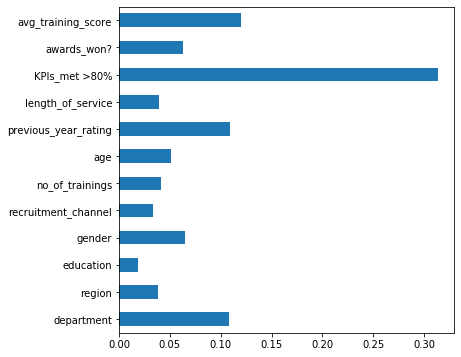

In [0]:
#Feature importance using Decision Tree model
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6,6)
coef=pd.Series(dtc.feature_importances_,index=X_dt.columns)
coef.plot(kind='barh')

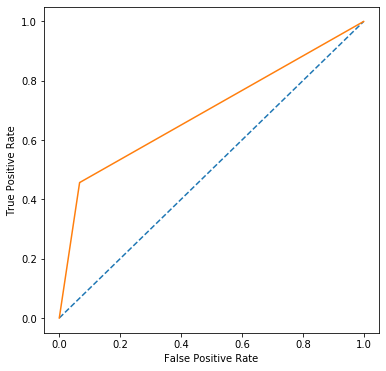

In [0]:
#ROC-AUC curve for Decision Tree Model
curve_roc(dtc,X_test.as_matrix(),y_test)

Decision Tree Classifier with GridSearchCV

In [0]:
#Defining parameters for GridSearchCV of Decision Tree
param_dtc={"criterion":['entropy','gini'],
           "max_depth":np.arange(25,31),
          "max_features":['auto','log2','sqrt'],
          "min_samples_split":np.arange(8,11)}

In [0]:
#Intializaing GridSearchCV with base estimator as Decision Tree and with 5 Fold Cross validation
dtc_cv=GridSearchCV(estimator=dtc,param_grid=param_dtc,cv=5)

In [0]:
#Applying GridSearchCV model on Training set
dtc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=0,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([25, 26, 27, 28, 29, 30]),
         

In [0]:
#Best estimator (Model) from GridSearchCV of Decision Tree model
dtc_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [0]:
#Prediction on test using Best Model of Decision Tree
y_pred_dtcv=dtc_cv.best_estimator_.predict(X_test)

In [0]:
#Calculating Accuracy score for Best Decision Tree model
accuracy_score(y_test,y_pred_dtcv)

0.897460224784703

In [0]:
#Calculating f1 score for Best Decision Tree model
f1_score(y_test,y_pred_dtcv)

0.3685393258426966

In [0]:
#Printing classification report for best decision tree model for evaluation
print(classification_report(y_test,y_pred_dtcv))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     12548
           1       0.38      0.36      0.37      1154

    accuracy                           0.90     13702
   macro avg       0.66      0.65      0.66     13702
weighted avg       0.89      0.90      0.90     13702



In [0]:
#ROC-AUC score for best decision tree model
roc_auc_score(y_test,y_pred_dtcv)

0.6513041221535993

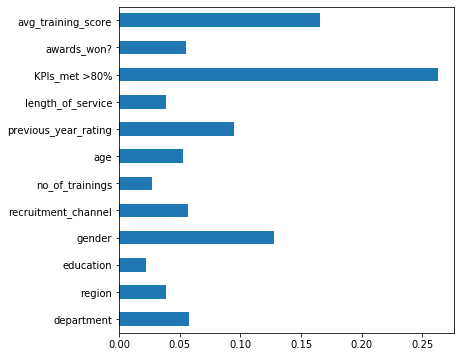

In [0]:
#Feature importance using best Decision Tree model
matplotlib.rcParams['figure.figsize'] = (6,6)
coef=pd.Series(dtc_cv.best_estimator_.feature_importances_,index=X_dt.columns)
coef.plot(kind='barh')

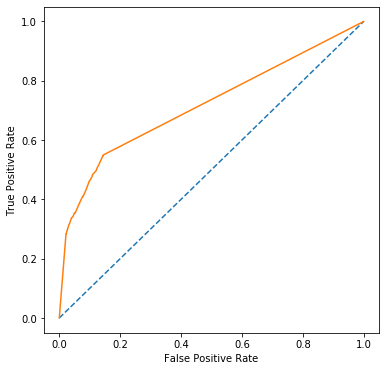

In [0]:
#ROC-AUC curve for best decision tree model
curve_roc(dtc_cv.best_estimator_,X_test.as_matrix(),y_test)

Random Forest Classifier

In [0]:
#Initializing Random Forest Classifier model
rfc=RandomForestClassifier(random_state=6)

In [0]:
#Fitting RFC model on training (without hyper parameter tunning)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

In [0]:
#Predictiing values of test set using basic RFC Model
y_pred_rfc=rfc.predict(X_test)

In [0]:
#Accuracy score of Basic RFC model
accuracy_score(y_test,y_pred_rfc)

0.9267990074441688

In [0]:
#f1 score fro basic RFC model
f1_score(y_test,y_pred_rfc)

0.4019081693500298

In [0]:
#Classification report for basic RFC model
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     12548
           1       0.64      0.29      0.40      1154

    accuracy                           0.93     13702
   macro avg       0.79      0.64      0.68     13702
weighted avg       0.91      0.93      0.91     13702



In [0]:
#ROC-AUC score for basic RFC model
roc_auc_score(y_test,y_pred_rfc)

0.6386023251304247

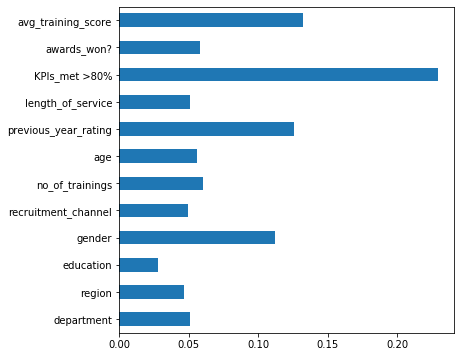

In [0]:
#Feature imporatance using basic RFC model
matplotlib.rcParams['figure.figsize'] = (6,6)
coef=pd.Series(rfc.feature_importances_,index=X_dt.columns)
coef.plot(kind='barh')

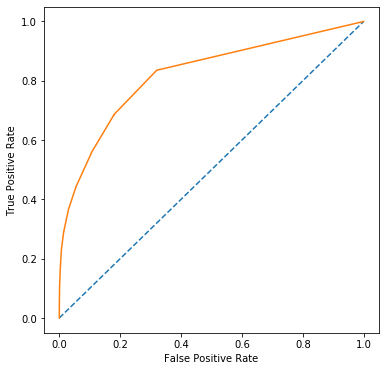

In [0]:
#ROC-AUC curve for basic RFC model
curve_roc(rfc,X_test.as_matrix(),y_test)

Random Forest Classifier using GridSearchCV

In [0]:
#Defining Hyper parameters for GridSearchCV of Random Forest Classifier
param_rfc={"criterion":['entropy','gini'],
           "max_depth":np.arange(10,16),
          "max_features":['auto','log2','sqrt'],
          "min_samples_split":np.arange(5,9)}

In [0]:
#Intializaing GridSearchCV model with RFC as base estimator and 5-fold cross validation
rfc_cv=GridSearchCV(estimator=rfc,param_grid=param_rfc,cv=5)

In [0]:
#Fitting GridSearchCV RFC model on training set
rfc_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=6,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'crite

In [0]:
#Best estimator for RFC after applying GridSearchCV
rfc_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=6, verbose=0,
                       warm_start=False)

In [0]:
#Predicting values for test set using best model of RFC
y_pred_rfccv=rfc_cv.best_estimator_.predict(X_test)

In [0]:
#Accuracy score for best model of RFC
accuracy_score(y_test,y_pred_rfccv)

0.9246825280980878

In [0]:
#f1 score for best model of RFC
f1_score(y_test,y_pred_rfccv)

0.42217245240761475

In [0]:
#Printing classification report best model of RFC
print(classification_report(y_test,y_pred_rfccv))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     12548
           1       0.60      0.33      0.42      1154

    accuracy                           0.92     13702
   macro avg       0.77      0.65      0.69     13702
weighted avg       0.91      0.92      0.91     13702



In [0]:
#ROC-AUC score for best model of RFC
roc_auc_score(y_test,y_pred_rfccv)

0.65318390551858

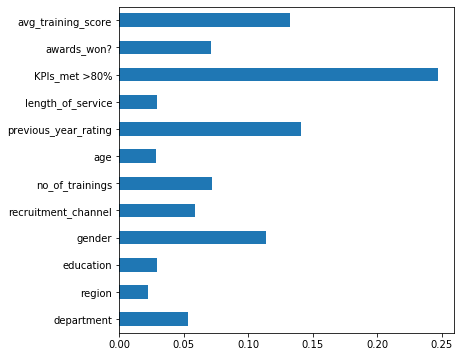

In [0]:
#Feature importance for best model of RFC
matplotlib.rcParams['figure.figsize'] = (6,6)
coef=pd.Series(rfc_cv.best_estimator_.feature_importances_,index=X_dt.columns)
coef.plot(kind='barh')

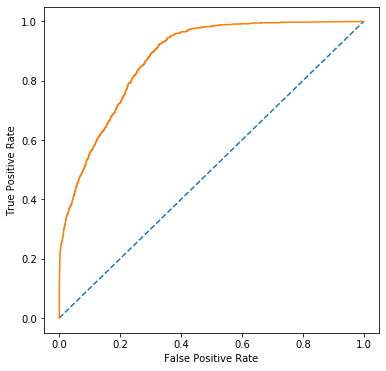

In [0]:
#ROC-AUC score for best model of RFC
curve_roc(rfc_cv.best_estimator_,X_test.as_matrix(),y_test)

XGBoost Classifier

In [0]:
#Initializing XGBoost model with random state 0
xgb=XGBClassifier(random_state=0)

In [0]:
#Fitting basic XGBoost model on training set
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#Prediciting values for test set using basic XGBoost model
y_pred_xgb=xgb.predict(X_test.as_matrix())

In [0]:
#Accuracy score for basic XGBoost model
accuracy_score(y_test,y_pred_xgb)

0.9226390307984236

In [0]:
#f1 score for basic XGBoost model
f1_score(y_test,y_pred_xgb)

0.3299620733249052

In [0]:
#Printing classification report for basic XGBoost model for evaluation
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12548
           1       0.61      0.23      0.33      1154

    accuracy                           0.92     13702
   macro avg       0.77      0.61      0.64     13702
weighted avg       0.91      0.92      0.91     13702



In [0]:
#ROC-AUC score for basic XGBoost model
roc_auc_score(y_test,y_pred_xgb)

0.6064304750865861

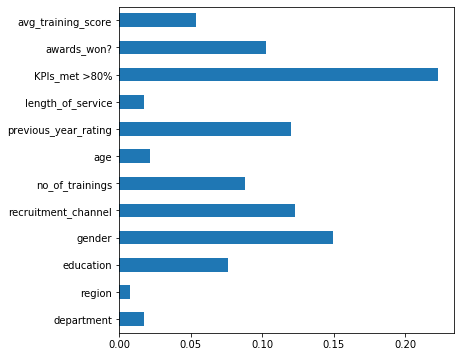

In [0]:
#Feature importance using basic XGBoost model
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6,6)
coef=pd.Series(xgb.feature_importances_,index=X_dt.columns)
coef.plot(kind='barh')

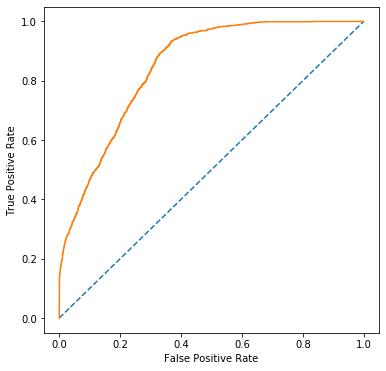

In [0]:
#ROC-AUC curve for basic XGBoost model
curve_roc(xgb,X_test.as_matrix(),y_test)

XGBoost Classifier using GridSearchCV

In [0]:
#Defining hyper parameters for GridSearchCV of XGBoost Classifier
param_xgb={"max_depth":np.arange(11,14),
          "learning_rate":np.arange(0.01,0.1,0.01),
          "n_estimators":[250,300]}

In [0]:
#Initializing GridSearchCV model with base estimator as XGBoost Classifier and 5-Fold Cross validation
xgb_cv=GridSearchCV(estimator=xgb,param_grid=param_xgb,cv=5)

In [0]:
#Fitting GridSearchCV model on training set
xgb_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'max_depth': array([11, 12, 13]),
   

In [0]:
#Best Estimator (Model) after GridSearchCV of XGBoost Classifier
xgb_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.04, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#Predicting values for test using best model of XGBoost 
y_pred_xgbcv=xgb_cv.best_estimator_.predict(X_test.as_matrix())

In [0]:
#Accuracy score for best model XGBoost Classifier
accuracy_score(y_test,y_pred_xgbcv)

0.94000875784557

In [0]:
#f1 score for best model of XGBoost Classifier
f1_score(y_test,y_pred_xgbcv)

0.5024213075060533

In [0]:
#Classification report for best model of XGBoost Classifier
print(classification_report(y_test,y_pred_xgbcv))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12548
           1       0.83      0.36      0.50      1154

    accuracy                           0.94     13702
   macro avg       0.89      0.68      0.74     13702
weighted avg       0.93      0.94      0.93     13702



In [0]:
#ROC-AUC score for best XGBoost Classifier
roc_auc_score(y_test,y_pred_xgbcv)

0.676502058784044

Text(0.5, 1.0, 'Feature Importance for XGBoost Best Estimator')

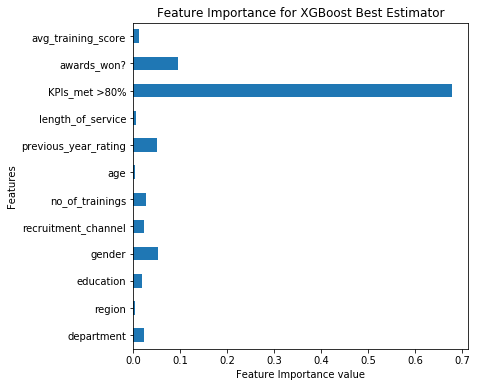

In [0]:
#Feature importance using best XGBoost Classifier
matplotlib.rcParams['figure.figsize'] = (6,6)
coef=pd.Series(xgb_cv.best_estimator_.feature_importances_,index=X_dt.columns)
coef.plot(kind='barh')
plt.xlabel("Feature Importance value")
plt.ylabel("Features")
plt.title("Feature Importance for XGBoost Best Estimator")

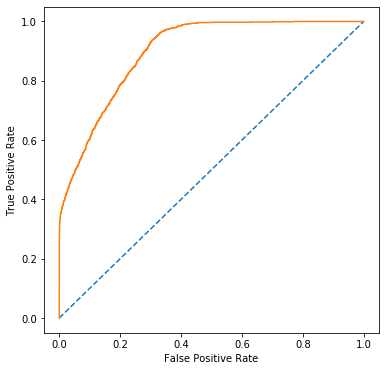

In [0]:
#ROC-AUC curve for Best XGBoost Classifier model
curve_roc(xgb_cv.best_estimator_,X_test.as_matrix(),y_test)

Naive Bayes

In [0]:
#Intializing Gaussian Naive Bayes Model
nb=GaussianNB()

In [0]:
#Fitting Gaussian Naive Bayes Model on Training set
nb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
#Predicting values using Gaussian Naive Bayes model
y_pred_nb=nb.predict(X_test)

In [0]:
#Accuracy score for Gaussian Naive Bayes model
accuracy_score(y_test,y_pred_nb)

0.7763100277331776

In [0]:
#f1 score for Gaussian Naive Bayes Model
f1_score(y_test,y_pred_nb)

0.29814517975727045

In [0]:
#Classification report for Gaussian Naive Bayes Model
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     12548
           1       0.20      0.56      0.30      1154

    accuracy                           0.78     13702
   macro avg       0.58      0.68      0.58     13702
weighted avg       0.89      0.78      0.82     13702



In [0]:
#ROC-AUC score for Gaussian Naive Bayes model
roc_auc_score(y_test,y_pred_nb)

0.6799744095325595

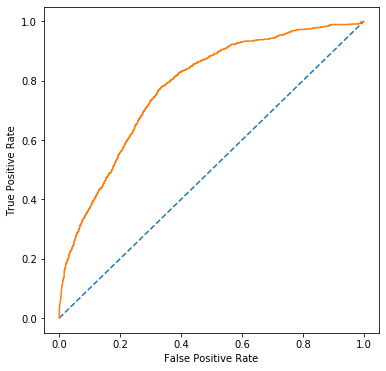

In [0]:
#ROC-AUC score for Gaussian Naive Bayes model
curve_roc(nb,X_test.as_matrix(),y_test)

In [0]:
acc_scores=[0.7860896219529996, 0.7857247117209166, 0.8931542840461246, 0.897460224784703, 0.9267990074441688, 0.9246825280980878, 0.9226390307984236, 0.94000875784557, 0.7763100277331776]
f1_scores=[0.3796825396825396, 0.3803292528493035, 0.4181240063593004, 0.3685393258426966, 0.4019081693500298, 0.42217245240761475, 0.3299620733249052, 0.5024213075060533, 0.29814517975727045]

In [0]:
x=["Linear Regression","Linear Regression with GridSearchCV",
   "Decision Tree Classifier","Decision Tree Classifier using GridSearchCV",
  "Random Forest Classifier","Random Forest Classifier using GridSearchCV",
  "XGBoost Classifier","XGBoost Classifier using GridSearchCV",
  "Naive Bayes Classifier"]

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

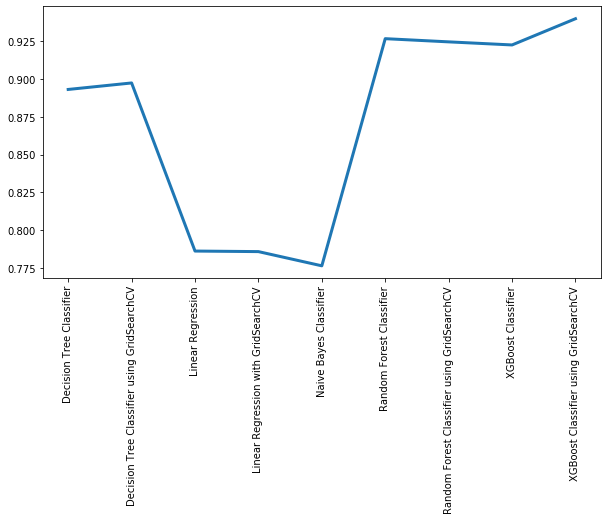

In [0]:
#Accuracy score plot for different models
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x,acc_scores,linewidth=3)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

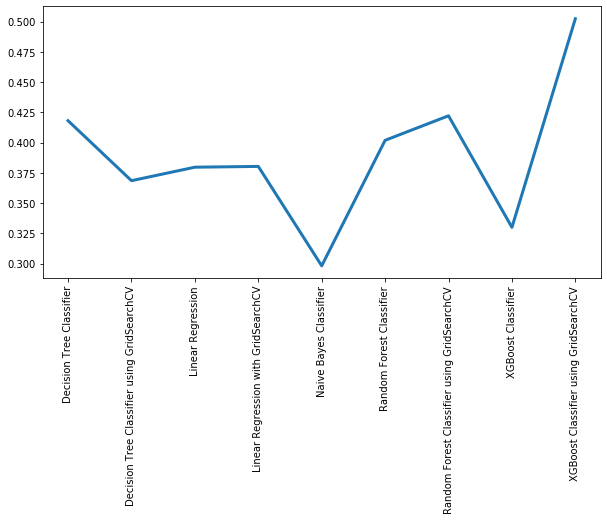

In [0]:
#f1 score plot for different models
plt.figure(figsize=(10,5))
sns.lineplot(x,f1_scores,linewidth=3,markers=True)
plt.xticks(rotation=90)